# HW3: topic modelling
### Катя Такташева

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [8]:
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [2]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [80]:
from string import punctuation


def preprocess(text, punct=True, lem=False):
    """
    preprocesses texts
    """
    text = re.sub('\S*@\S*\s?', '', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub("\'", "", text)
    if punct == False:
        words = []
        for word in text.split():
            words.append(word.strip(punctuation))
        text = ' '.join(words)
    if lem == True:
        text = ' '.join([i.lemma_ for i in nlp(text)])
    return text.strip()

In [4]:
df['preprocessed'] = df['content'].apply(preprocess)

In [5]:
df.head()

,content,target,target_names,preprocessed
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos,From: (wheres my thing) Subject: WHAT car is t...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware,From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware,From: (Thomas E Willis) Subject: PB questions....
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics,From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space,From: (Jonathan McDowell) Subject: Re: Shuttle...


In [9]:
def sent_to_words(sentences):
    """
    creates word lists
    """
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df.preprocessed.tolist()))

In [10]:
bigrams = [b for sent in data_words for b in zip(sent[:-1], sent[1:])]
freq = nltk.FreqDist(bigrams) 
fdist = freq.keys()

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [13]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Mallet совсем никак не хочет работать на маке, пробовала и в колабе и на локал хосте :( вообще все пишут, что эта проблема прям очень частая и все решения на десятке сайтов работают у людей с переменным успехом..

In [16]:
mallet_path = '/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus, 
                                             num_topics=3, 
                                             id2word=id2word,
                                             alpha='auto')

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

CalledProcessError: Command '/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/gs/wv6n0xks3s15ys1bvtd7brq40000gn/T/d8484f_corpus.txt --output /var/folders/gs/wv6n0xks3s15ys1bvtd7brq40000gn/T/d8484f_corpus.mallet' returned non-zero exit status 127.

### Найдем оптимальное количество топиков

In [82]:
def find_best_param(groups: list):
    """
    finds the optimal number of topics
    for the given corpora according to
    coherence score
    """
    scores = []
    for n in groups:
        print('* ' * 30)
        print(f'n_topics={n}')
        print('Extracting topics...')
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=n, 
                                                    random_state=100,
                                                    update_every=1,
                                            
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
        print('Coherence score...')
        coherence_model_lda = CoherenceModel(model=lda_model, 
                                             texts=data_lemmatized, 
                                             dictionary=id2word, 
                                             coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print(f'Finished with coherence score {coherence_lda}')
        scores.append((n, coherence_lda))
        
    scores = sorted(scores, key=lambda x: -x[1])
    print('* ' * 30)
    print(f'Best score: {scores[0][1]} with {scores[0][0]} topics')
    return scores

In [20]:
topics = [5, 6, 7, 8, 9, 10, 15, 20, 25, 30]

best_n = find_best_param(topics)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
n_topics=5
Extracting topics...
Coherence score...
Finished with coherence score 0.556162379991811
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
n_topics=6
Extracting topics...
Coherence score...
Finished with coherence score 0.5298558581887968
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
n_topics=7
Extracting topics...
Coherence score...
Finished with coherence score 0.5347721693950162
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
n_topics=8
Extracting topics...
Coherence score...
Finished with coherence score 0.4667539140125066
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
n_topics=9
Extracting topics...
Coherence score...
Finished with coherence score 0.529042485995545
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
n_topics=10
Extracting topics...
Coherence score...
Finished with coherence score 0.5047573814189
* * * * * * * * * * * * * * * * * * * 

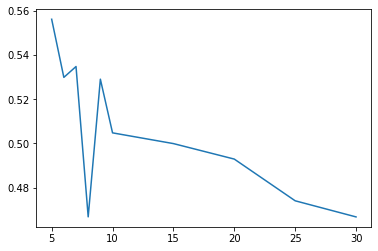

In [21]:
import matplotlib.pyplot as plt


plt.plot([s[0] for s in sorted(best_n)], [s[1] for s in sorted(best_n)]);

Оптимальное число групп равно 5, значит, обучим модель с 5 темами:

In [60]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=5, 
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)

In [65]:
topics = lda_model.show_topics(5, 1000, formatted=False)  # достанем все темы и по 1000 слов к каждой 
doc_lda = lda_model[corpus]

### Найдем широкие топики

In [69]:
def get_topic_words(topic):
    """
    creates a dictionary of 
    topic words and their weights
    """
    dic = {}     
    for word in topic:
        dic[word[0]] = float(word[1])
    return dic


def topics_dict(topics):
    """
    creates a dictionary of topic words
    """
    top_dict = {}
    for topic in topics:
        top_dict[str(topic[0])] = get_topic_words(topic[1])
    return top_dict


def find_topic(text, topics):
    """
    returns the most prominent topic 
    of the text
    """
    text_top = {}
    for topic in topics:
        for word in text:
            if word in topics[topic]:
                if topic not in text_top:
                    text_top[topic] = 0
                text_top[topic] += topics[topic][word]
    text_top = sorted(text_top.items(), key=lambda x: -x[1])
    # есть пара текстов, где после препроцессинга остается ничего - отсюда None
    return text_top[0][0] if len(text_top) >= 1 else None 

In [70]:
from tqdm.auto import tqdm


def classify(data, topics, org_df):
    """
    classifies texts
    """
    # Creating topic dictionary
    top_dict = topics_dict(topics)
    
    df = []
    
    # Classifying
    for i, text in tqdm(enumerate(data)):
        topic = find_topic(text, top_dict)
        df.append((org_df.loc[i, 'content'], ' '.join(text), topic))
    return pd.DataFrame(df, columns=['text', 'lemmas', 'topic'])

In [71]:
my_df = classify(data_lemmatized, topics, df)

In [72]:
my_df

,text,lemmas,topic
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,where thing car nntp_poste host park line wond...,3
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,si poll final summary final call si clock repo...,0
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,question engineering computer network distribu...,3
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,division line host amber write write article k...,3
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,question organization smithsonian_astrophysica...,1
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,migraine city ny_bis reply line cheap also wel...,3
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,problem screen blank sometimes minor physical ...,0
11311,From: westes@netcom.com (Will Estes)\nSubject:...,este mount case organization mail group line i...,3
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,line nntp_poste host article write boy embaras...,3


In [73]:
my_df['topic'].unique()

array(['3', '0', '1', '2', '4', None], dtype=object)

### TF-IDF по темам
Там не очень понятное задание, как я поняла, для каждой темы считаем tf-idf (то есть корпус - это все тексты, принадлежащие к одной теме)

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
from operator import itemgetter


def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def topic_tfidf(texts, topn=500):
    vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True,
                                 min_df=0.01, ngram_range=(1,1),
                                 stop_words=set([punctuation]+stop_words))
    
    collection = ' '.join(texts) if type(texts) == list else texts
    X = vectorizer.fit_transform([collection])
    feature_names = vectorizer.get_feature_names()
    from_sorted=sort_coo(X.tocoo())[:topn]
    scores, features = [], []
    for idx, score in from_sorted:
        scores.append(round(score, 3))
        features.append(feature_names[idx])
    important_words = {features[idx]: scores[idx] for idx in range(len(features))}
    important_words = sorted(important_words.items(), key=itemgetter(1), reverse=True)
    return important_words

In [86]:
tfidf_topics = {}

for t in my_df['topic'].unique()[:-1]:
    tfidf_topics[t] = {}
    texts = my_df[my_df['topic']==t].lemmas.tolist()
    top_words = topic_tfidf(texts)
    for word, score in top_words:
        tfidf_topics[t][word] = score

In [87]:
new_df = []
for t in tqdm(my_df['topic'].unique()):
    curr_df = my_df[my_df['topic']==t]
    for i, text in curr_df.iterrows():
        words = []
        for word in text['lemmas'].split():
            if word in tfidf_topics[t]:
                words.append((word, tfidf_topics[t][word]))
        words = list(set(sorted(words, key=lambda x: -x[1])))[:5]
        words = ', '.join([w[0] for w in words])
        new_df.append((text['text'], text['topic'], words))

In [88]:
new_df = pd.DataFrame(new_df, columns=['text', 'topic', 'tfidf_words'])

In [91]:
new_df.head()

,text,topic,tfidf_words
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,3,"bring, call, early, really, door"
1,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,3,"start, suppose, maybe, news, time"
2,From: jgreen@amber (Joe Green)\nSubject: Re: W...,3,"far, address, write, person, really"
3,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,3,"would, several, mail, line, appreciate"
4,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,3,"owner, however, correct, write, mention"


In [92]:
new_df.to_csv('hw3_gensim_topics.csv', sep='\t')

### Coherence score

**Что такое coherence топика?**
    - Связность текстов внутри одной темы, в частности, семантическая соотнесенность слов, выделяемых как самые наиболее вероятные (с наибольшим весом) в теме
**Как работает coherence score?**
    - у нас есть sliding wondow, своеобразное окно наблюдение с размером 110, которое проходится по частотным словам в топике
    - считается co-occurence слов, т.е. частота появления двух терминов из текстового корпуса рядом друг с другом
    - затем эти данные используются для подсчета NPMI (упрощенно, вероятности схожести) для пар высокочастотных слов -- получаем вектора для слов
    - в конце производится one-set segmentation по самым вероятным словам и в результате получается, что подсчитывается косинусная близость между всеми векторами частотных слов и сумма всех этих векторов, а coherence - это среднее значение всех косинусных близостей. 